Un CNN classifieur pour utiliser ELMo. Implémentation de version Tensorflow. Les codes de CNN sont basé sur https://github.com/gaussic/text-classification-cnn-rnn et la partie d'intégration de ELMo bilm est modifié depuis les scripts sur [bilm-tf](https://github.com/allenai/bilm-tf)

In [1]:
import ast
import re
import os
import keras
from keras.layers import Dense, Embedding, Input
from keras.layers import GRU, Dropout, MaxPooling1D, Conv1D, Flatten, LSTM
from keras.models import Model
from keras import backend as K
import numpy as np
import itertools
from keras.utils import np_utils, Sequence
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
from sklearn import preprocessing
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from plot_util import plot_confusion_matrix
import time
import h5py
%matplotlib inline
import tensorflow as tf
import os
import sys
import json
import gc
sys.path.append("..")
    
from bilm_tf.bilm import TokenBatcher, BidirectionalLanguageModel, \
weight_layers, dump_token_embeddings

Using TensorFlow backend.


# Data Loader

In [2]:
def filter(s):
    """Output only Chinese, English characters and Arabic numerals"""
    filtrate = re.compile(u'[^\u0030-\u0039\u0041-\u005A\u0061-\u007A\u4E00-\u9FA5]')
    res = filtrate.sub(r' ', s)
    return res

def read_datasets(data_path):
    """read datasets form files"""
    x, y = [], []
    with open(data_path, 'r') as f:
        for line in f:
            try:
                content, label = line.strip().split('__label__')
                if content:
                    x.append(filter(content).replace('  ', ''))
                    y.append(label.replace('\n', ''))
            except:
                pass
    print(len(x))
    return x, y

def read_vocab(vocab_dir):
    with open(vocab_dir, 'r') as f:
        words = [_.strip() for _ in f.readlines()]
    word_to_id = dict(zip(words, range(len(words))))
    return words, word_to_id

def read_category(data_path):
    """get classes list and corresponding id list"""
    x, y = read_datasets(data_path)
    categories = np.unique(y)
    cat_to_id = dict(zip(categories, range(len(categories))))
    
    return categories, cat_to_id

def process_datasets(data_path, word_to_id, cat_to_id, max_length, vocab_size):
    """transform words and labels to id, pad the examples"""
    print('Converting data to trainable form...')
    contents, labels = read_datasets(data_path)
    
    data_id, label_id = [], []
    for i in range(len(contents)):
        data_id.append([word_to_id[x] for x in contents[i] if x in word_to_id])
        label_id.append(cat_to_id[labels[i]])
        
    x_pad = sequence.pad_sequences(data_id, maxlen=max_length)
    y_pad = keras.utils.to_categorical(label_id, num_classes=len(cat_to_id))
    print('Number of examples counted by x_pad: ' + str(len(x_pad)))
    print('Number of examples counted by y_pad: ' + str(len(y_pad)))
    
    return x_pad, y_pad

def batch_iter(x, y, batch_size=128):
    """generate batch data"""
    data_len = len(x)
    num_batch = (data_len - 1) // batch_size + 1
#     if (data_len - 1) % batch_size != 0:
#         num_batch = num_batch + 1
    
    indices = np.random.permutation(np.arange(data_len))
    x_shuffle = x[indices]
    y_shuffle = y[indices]
    
    for i in range(num_batch):
        start_id = i * batch_size
        end_id = min((i + 1) * batch_size, data_len)
        yield x_shuffle[start_id:end_id], y_shuffle[start_id:end_id]

In [5]:
class TCNNConfig(object):
    """CNN parrameters config"""
    embedding_dim = 600  # embedding_size
    seq_length = 1002 # max length for each news
    num_classes = 11  
    num_filters = 32  # number of filters
    kernel_size = 5  # conv kernel size
    vocab_size = 5000

    hidden_dim = 512  # number of units in fc1
    
    dropout_keep_prob = 0.5 
    learning_rate = 1e-3

    batch_size = 128  
    num_epochs = 2  

    print_per_batch = 100  
    save_per_batch = 10  # save into tensorboard
    

class TextCNN(object):
    """Text Classification, CNN Model"""
    
    def __init__(self, config):
        self.config = config
        # inputs
        self.input_x = tf.placeholder(tf.float32,
                                      [None, self.config.seq_length - 2, self.config.embedding_dim], 
                                      name='input_x')
        self.input_y = tf.placeholder(tf.float32,
                                      [None, self.config.num_classes],
                                      name='input_y')
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        self.cnn()
    
    def cnn(self):
        """CNN Model"""
        
        with tf.name_scope("cnn"):
            # inputs shape : [batch, filter_width, in_channels]
            # filters shape : [filter_width, in_channels, out_channels]
            
            # CNN layer
            conv = tf.layers.conv1d(self.input_x, 
                                    filters=32,
                                    kernel_size=5,
                                    strides=1, 
                                    padding='same',
                                    name='conv')
            conv_relu = tf.nn.relu(conv)
            conv_dropout = tf.contrib.layers.dropout(conv_relu, keep_prob=self.keep_prob)
            
            # max pooling layer
            mpl = tf.layers.max_pooling1d(conv_dropout,
                                          pool_size=2,
                                          strides=1,
                                          padding='valid',
                                          name='mpl')
        
        with tf.name_scope("score"):
            fc = tf.layers.flatten(mpl)
            fc = tf.layers.dense(fc, units=512, activation=tf.nn.relu, name='fc1')
            fc_dropout = tf.contrib.layers.dropout(fc, keep_prob=self.keep_prob)
            self.logits = tf.layers.dense(fc_dropout, units=11, name='fc2')
            self.y_pred_cls = tf.argmax(tf.nn.softmax(self.logits), 1)

        with tf.name_scope("optimize"):
            # loss function, cross entropy
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits,
                                                                    labels=self.input_y)
            self.loss = tf.reduce_mean(cross_entropy)
            # opptimizer
            self.optim = tf.train.AdamOptimizer(learning_rate=self.config.learning_rate).minimize(self.loss)
        
        
        with tf.name_scope("accuracy"):
            # accuracy
            correct_pred = tf.equal(tf.argmax(self.input_y, 1), self.y_pred_cls)
            self.acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Run CNN Model

In [6]:
import os
import time
from datetime import timedelta
from sklearn import metrics

base_dir = 'datasets/'
train_dir = os.path.join(base_dir, 'news_less_category.txt')
test_dir = os.path.join(base_dir, 'news_fasttext_test.txt')
vocab_dir = 'pre_trained_vectors/raw_300/ft_5_vocab.txt'
save_dir = 'checkpoints/textcnn'
vocab_file = '/home/chenxin/WordEmbedding/pre_trained_vectors/raw_300/ft_5_vocab.txt'
options_file = '/home/chenxin/ELMo/pure_checkpoint/options.json'
weight_file = '/home/chenxin/ELMo/pure_checkpoint/weights.hdf5'
token_embedding_file = '/home/chenxin/WordEmbedding/pre_trained_vectors/raw_300/vocab_embedding.hdf5'
prefix = 'pre_trained_vectors/elmo_600/elmo_vector_'

with open(options_file, 'r') as fin:
    options = json.load(fin)

tf.reset_default_graph()
categories, cat_to_id = read_category(train_dir)
config = TCNNConfig()
words, word_to_id = read_vocab(vocab_dir)
config.vocab_size = len(words)
model = TextCNN(config)
## Now we can do inference.
# Create a TokenBatcher to map text to token ids.
batcher = TokenBatcher(vocab_file)

# Input placeholders to the biLM.
context_token_ids = tf.placeholder('int32', shape=(None, None))

# Build the biLM graph.
bilm = BidirectionalLanguageModel(
    options_file,
    weight_file,
    use_character_inputs=False,
    embedding_weight_file=token_embedding_file
)

# Get ops to compute the LM embeddings.
context_embeddings_op = bilm(context_token_ids)

#with tf.variable_scope('', reuse=True):
elmo_context_input = weight_layers('input', context_embeddings_op, l2_coef=0.0)

#with tf.variable_scope('', reuse=True):
elmo_context_output = weight_layers('output', context_embeddings_op, l2_coef=0.0)

def plot_conf_mat(y_test, y_predicted, categories):
    conf_mat = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plot_confusion_matrix(conf_mat, categories, title='Confusion matrix, without normalization')
    plt.subplot(122)
    plot_confusion_matrix(conf_mat, categories, normalize=True, title='Normalized confusion matrix')
    
def get_time_diff(start_time):
    """get time passed"""
    end_time = time.time()
    time_diff = end_time - start_time
    return timedelta(seconds=int(round(time_diff)))

def feed_data(x_batch, y_batch, keep_prob):
    feed_dict = {
        model.input_x: x_batch,
        model.input_y: y_batch,
        model.keep_prob: keep_prob
    }
    return feed_dict

def evaluate(sess, x_, y_):
    """evaluate the accuracy and loss on an example"""
    data_len = len(x_)
    batch_eval = batch_iter(x_, y_, 128)
    total_loss = 0.0
    total_acc = 0.0
    for x_batch, y_batch in batch_eval:
        batch_len = len(x_batch)
        feed_dict = feed_data(x_batch, y_batch, 1.0)
        loss, acc = sess.run([model.loss, model.acc], feed_dict=feed_dict)
        # loss and acc calculated the mean loss and acc of the batch, so we need to multiply the batch_len  
        total_loss += loss * batch_len
        total_acc += acc * batch_len

    return total_loss / data_len, total_acc / data_len

def train():
    print("Configuring TensorBoard and Saver...")
    # config Tensorboard，delete tensorboard folder for re-training
    tensorboard_dir = 'tensorboard/textcnn'
    if not os.path.exists(tensorboard_dir):
        os.makedirs(tensorboard_dir)
    
    tf.summary.scalar("loss", model.loss)
    tf.summary.scalar("accuracy", model.acc)
    merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter(tensorboard_dir)
    
    # config saver
    saver = tf.train.Saver()
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    print("Loading training and validation data...")
    start_time = time.time()
    x, y = process_datasets(train_dir, word_to_id, cat_to_id,
                            max_length=config.seq_length,
                            vocab_size=config.vocab_size)
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1)
    time_diff = get_time_diff(start_time)
    print("Time usage:", time_diff)
    
    # Create session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        writer.add_graph(sess.graph)

        print("Training and evaluating...")
        start_time = time.time()
        total_batch = 0 # total batch
        best_acc_val = 0.0 # best validation set accurary
        last_improved = 0 # record last improved batch
        # if more than 1000 batches, we don't get improvement, we terminate training phase
        require_improvement = 500
        
        flag = False
        num_batch_val = len(x_val) // config.batch_size
        for epoch in range(config.num_epochs):
            print("Epoch:", epoch + 1)
            batch_train = batch_iter(x_train, y_train, config.batch_size)
            for x_batch, y_batch in batch_train:
                # TODO: add bilm context input
                # Compute ELMo representations (here for the input only, for simplicity).
                elmo_context_input_ = sess.run(
                    [elmo_context_input['weighted_op']],
                    feed_dict={context_token_ids: x_batch}
                )
#                 elmo_context_input_ = np.array(elmo_context_input_)
                         
                feed_dict = feed_data(elmo_context_input_[0], y_batch, config.dropout_keep_prob)
                
                if total_batch % config.save_per_batch == 0:
                    s = sess.run(merged_summary, feed_dict=feed_dict)
                    writer.add_summary(s, total_batch)
                    
                if total_batch % config.print_per_batch == 0:
                    feed_dict[model.keep_prob] = 1.0
                    loss_train, acc_train = sess.run([model.loss, model.acc],
                                                     feed_dict=feed_dict)
                    
                    
                    current_batch = total_batch % num_batch_val
                    x_val_batch = x_val[current_batch * config.batch_size:(current_batch + 1) * config.batch_size]
                    y_val_batch = y_val[current_batch * config.batch_size:(current_batch + 1) * config.batch_size]
                    elmo_context_input_ = sess.run(
                        [elmo_context_input['weighted_op']],
                        feed_dict={context_token_ids: x_val_batch})
                    feed_dict = feed_data(elmo_context_input_[0], y_val_batch, 1.0)
                    loss_val, acc_val = sess.run([model.loss, model.acc], feed_dict=feed_dict)
                    if acc_val > best_acc_val:
                        # Save the best result
                        best_acc_val = acc_val
                        last_improved = total_batch
                        saver.save(sess=sess, save_path=save_dir)
                        improved_str = '*'
                    else:
                        improved_str = ''
                        
                    time_diff = get_time_diff(start_time)
                    msg = 'Iter: {0:>6}, Train Loss: {1:>6.2}, Train Acc: {2:>7.2%},' \
                      + ' Val Loss: {3:>6.2}, Val Acc: {4:>7.2%}, Time: {5} {6}'
                    print(msg.format(total_batch, loss_train, acc_train, loss_val,
                                     acc_val, time_diff, improved_str))
                sess.run(model.optim, feed_dict=feed_dict) # run optimization
                total_batch += 1
                
                if total_batch - last_improved > require_improvement:
                    print("No optimization for a long time, auto-stopping...")
                    flag = True
                    break
            if flag:
                break
                
def test():
    print("Loading test data...")
    start_time = time.time()
    x_test, y_test = process_datasets(test_dir, word_to_id, cat_to_id, config.seq_length, config.vocab_size)
    print(y_test.shape)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        saver.restore(sess=sess, save_path=save_dir)
        
        print("Testing...")
        total_loss_test = 0
        total_acc_test = 0
        count = 0
        batch_test = batch_iter(x_test, y_test, config.batch_size)
        for x_test_batch, y_test_batch in batch_test:
            elmo_context_input_ = sess.run(
                [elmo_context_input['weighted_op']],
                feed_dict={context_token_ids: x_test_batch}
            )
            feed_dict = feed_data(elmo_context_input_[0], y_test_batch, 1.0)
            loss_test, acc_test = sess.run([model.loss, model.acc], feed_dict=feed_dict)
            total_loss_test += loss_test * config.batch_size
            total_acc_test += acc_test * config.batch_size
            
        data_len = len(x_test)
        total_loss_test /= data_len
        total_acc_test /= data_len
        
        msg = 'Test Loss: {0:>6.2}, Test Acc: {1:>7.2%}'
        print(msg.format(total_loss_test, total_acc_test))
        
        batch_size = config.batch_size
        num_batch = (data_len - 1) // batch_size + 1
        
        y_test_cls = np.argmax(y_test, 1)
        y_pred_cls = np.zeros(shape=len(x_test), dtype=np.int32)
        for i in range(num_batch):
            start_id = i * batch_size
            end_id = min((i + 1) * batch_size, data_len)
            elmo_context_input_ = sess.run(
                    [elmo_context_input['weighted_op']],
                    feed_dict={context_token_ids: x_test[start_id:end_id]}
                )
            feed_dict = {
                model.input_x: elmo_context_input_[0],
                model.keep_prob: 1.0
            }
            y_pred_cls[start_id:end_id] = sess.run(model.y_pred_cls, feed_dict=feed_dict)
            if i % 100 == 0:
                msg = 'Iter: {0:>6}'
                print(msg.format(i))
        
        print("Precision, Recall and F1-Score...")
        print(metrics.classification_report(y_test_cls, y_pred_cls, target_names=categories))
        
        print("Confusion Matrix...")
        plot_conf_mat(y_test_cls, y_pred_cls, categories)
#         cm = metrics.confusion_matrix(y_test_cls, y_pred_cls)
#         print(cm)
        
        time_diff = get_time_diff(start_time)
        print("Time usage: ", time_diff)

        
def run_cnn(argv):
    if argv not in ['train', 'test']:
        raise ValueError("Wrong argument.")
        
    print("Configuring CNN Model...")
    
    if argv == 'train':
        train()
    else:
        test()

109989
USING SKIP CONNECTIONS


In [7]:
run_cnn('train')

Configuring CNN Model...
Configuring TensorBoard and Saver...
Loading training and validation data...
Converting data to trainable form...
109989
Number of examples counted by x_pad: 109989
Number of examples counted by y_pad: 109989
Time usage: 0:00:24
Training and evaluating...
Epoch: 1
Iter:      0, Train Loss:    2.5, Train Acc:  10.16%, Val Loss:    2.4, Val Acc:   6.25%, Time: 0:00:10 *
Iter:    100, Train Loss:    2.3, Train Acc:  22.66%, Val Loss:    2.3, Val Acc:  20.31%, Time: 0:05:38 *
Iter:    200, Train Loss:    2.0, Train Acc:  35.94%, Val Loss:    1.9, Val Acc:  37.50%, Time: 0:11:07 *
Iter:    300, Train Loss:    1.4, Train Acc:  52.34%, Val Loss:    1.5, Val Acc:  52.34%, Time: 0:16:36 *
Iter:    400, Train Loss:   0.89, Train Acc:  71.88%, Val Loss:    1.0, Val Acc:  67.97%, Time: 0:22:04 *
Iter:    500, Train Loss:   0.99, Train Acc:  67.19%, Val Loss:   0.74, Val Acc:  75.78%, Time: 0:27:33 *
Iter:    600, Train Loss:   0.91, Train Acc:  71.09%, Val Loss:   0.86, Va

Configuring CNN Model...
Loading test data...
Converting data to trainable form...
103369
Number of examples counted by x_pad: 103369
Number of examples counted by y_pad: 103369
(103369, 11)
INFO:tensorflow:Restoring parameters from checkpoints/textcnn
Testing...
Test Loss:   0.68, Test Acc:  78.41%
Iter:      0
Iter:    100
Iter:    200
Iter:    300
Iter:    400
Iter:    500
Iter:    600
Iter:    700
Iter:    800
Precision, Recall and F1-Score...
              precision    recall  f1-score   support

     affairs       0.85      0.72      0.78     10000
    economic       0.60      0.85      0.70     10000
         edu       0.95      0.87      0.91     10000
         ent       0.64      0.91      0.75     10000
     fashion       0.63      0.81      0.71      3369
        game       0.88      0.89      0.89     10000
        home       0.75      0.66      0.70     10000
       house       0.87      0.80      0.83     10000
     science       0.81      0.57      0.67     10000
      s

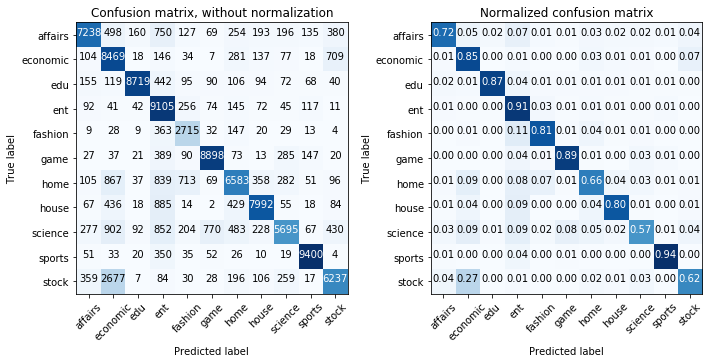

In [8]:
run_cnn('test')